In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy import stats
import joblib

In [111]:
# Chargement des données
data = pd.read_csv("data/airplane_price_dataset.csv")
print("Aperçu des données :")
display(data.head())
print(f"\nLignes: {data.shape[0]}, Colonnes: {data.shape[1]}")
print("\nInformations sur les données :")
display(data.info())
print("\nStatistiques descriptives :")
display(data.describe())

# Renommage des colonnes
data.rename(columns={
    "Model": "Modèle",
    "Üretim Yılı": "Année de production",
    "Motor Sayısı": "Nombre de moteurs",
    "Motor Türü": "Type de moteur",
    "Kapasite": "Capacité",
    "Menzil (km)": "Autonomie (km)",
    "Yakıt Tüketimi (L/saat)": "Consommation de carburant (L/h)",
    "Saatlik Bakım Maliyeti ($)": "Coût de maintenance horaire ($)",
    "Yaş": "Âge",
    "Satış Bölgesi": "Région de vente",
    "Fiyat ($)": "Prix ($)"
}, inplace=True)
print("Après renommage")
display(data.head())

Aperçu des données :


,Model,Üretim Yılı,Motor Sayısı,Motor Türü,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Satış Bölgesi,Fiyat ($)
0,Bombardier CRJ200,1987,2,Turbofan,50,3000,14.36,2185.43,36,Asya,1.285708e+07
1,Bombardier CRJ200,1997,2,Turbofan,50,3000,4.03,1202.08,26,Avrupa,1.391406e+07
2,Airbus A320,1988,2,Turbofan,180,6300,13.26,761.38,35,Avustralya,9.073570e+07
3,Boeing 737,2023,2,Turbofan,162,5700,14.61,592.63,0,Avustralya,1.366597e+08
4,Cessna 172,1985,1,Piston,4,1285,18.49,4245.99,38,Güney Amerika,2.037981e+05



Lignes: 12377, Colonnes: 11

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12377 entries, 0 to 12376
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Model                       12377 non-null  object 
 1   Üretim Yılı                 12377 non-null  int64  
 2   Motor Sayısı                12377 non-null  int64  
 3   Motor Türü                  12377 non-null  object 
 4   Kapasite                    12377 non-null  int64  
 5   Menzil (km)                 12377 non-null  int64  
 6   Yakıt Tüketimi (L/saat)     12377 non-null  float64
 7   Saatlik Bakım Maliyeti ($)  12377 non-null  float64
 8   Yaş                         12377 non-null  int64  
 9   Satış Bölgesi               12377 non-null  object 
 10  Fiyat ($)                   12377 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ MB


None


Statistiques descriptives :


,Üretim Yılı,Motor Sayısı,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Fiyat ($)
count,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,1.237700e+04
mean,2001.477660,1.835259,190.413994,7782.210148,12.075615,2744.089599,21.522340,1.988336e+08
std,12.766785,0.370962,142.662710,5492.478746,9.905418,1293.209611,12.766785,2.290392e+08
min,1980.000000,1.000000,4.000000,1285.000000,2.000000,500.020000,0.000000,1.458148e+05
25%,1990.000000,2.000000,50.000000,3000.000000,5.950000,1627.260000,10.000000,1.409681e+07
50%,2001.000000,2.000000,162.000000,5700.000000,9.820000,2744.330000,22.000000,8.392191e+07
75%,2013.000000,2.000000,350.000000,14800.000000,13.470000,3848.840000,33.000000,3.843239e+08
max,2023.000000,2.000000,396.000000,15600.000000,49.970000,4999.660000,43.000000,9.782132e+08


Après renommage


,Modèle,Année de production,Nombre de moteurs,Type de moteur,Capacité,Autonomie (km),Consommation de carburant (L/h),Coût de maintenance horaire ($),Âge,Région de vente,Prix ($)
0,Bombardier CRJ200,1987,2,Turbofan,50,3000,14.36,2185.43,36,Asya,1.285708e+07
1,Bombardier CRJ200,1997,2,Turbofan,50,3000,4.03,1202.08,26,Avrupa,1.391406e+07
2,Airbus A320,1988,2,Turbofan,180,6300,13.26,761.38,35,Avustralya,9.073570e+07
3,Boeing 737,2023,2,Turbofan,162,5700,14.61,592.63,0,Avustralya,1.366597e+08
4,Cessna 172,1985,1,Piston,4,1285,18.49,4245.99,38,Güney Amerika,2.037981e+05


In [112]:
# Détection des valeurs aberrantes avec l'IQR
def detect_outliers_iqr(df):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers_iqr = detect_outliers_iqr(data)
print("\nDétection des valeurs aberrantes (IQR) :")
for col, outlier_values in outliers_iqr.items():
    print(f"Valeurs aberrantes dans {col} : {len(outlier_values)} valeurs")

# Détection des valeurs aberrantes avec le Z-score
def detect_outliers_zscore(df, threshold=3):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:
        z_scores = stats.zscore(df[col].dropna())
        outliers[col] = df[col][(z_scores > threshold) | (z_scores < -threshold)]
    return outliers

outliers_zscore = detect_outliers_zscore(data)
print("\nDétection des valeurs aberrantes (Z-score) :")
for col, outlier_values in outliers_zscore.items():
    print(f"Valeurs aberrantes dans {col} : {len(outlier_values)} valeurs")


Détection des valeurs aberrantes (IQR) :
Valeurs aberrantes dans Année de production : 0 valeurs
Valeurs aberrantes dans Nombre de moteurs : 2039 valeurs
Valeurs aberrantes dans Capacité : 0 valeurs
Valeurs aberrantes dans Autonomie (km) : 0 valeurs
Valeurs aberrantes dans Consommation de carburant (L/h) : 1286 valeurs
Valeurs aberrantes dans Coût de maintenance horaire ($) : 0 valeurs
Valeurs aberrantes dans Âge : 0 valeurs
Valeurs aberrantes dans Prix ($) : 4 valeurs

Détection des valeurs aberrantes (Z-score) :
Valeurs aberrantes dans Année de production : 0 valeurs
Valeurs aberrantes dans Nombre de moteurs : 0 valeurs
Valeurs aberrantes dans Capacité : 0 valeurs
Valeurs aberrantes dans Autonomie (km) : 0 valeurs
Valeurs aberrantes dans Consommation de carburant (L/h) : 422 valeurs
Valeurs aberrantes dans Coût de maintenance horaire ($) : 0 valeurs
Valeurs aberrantes dans Âge : 0 valeurs
Valeurs aberrantes dans Prix ($) : 23 valeurs


$$
z = \frac{x - \mu}{\sigma}
$$

avec :

* $x$ : la valeur observée
* $\mu$ : la moyenne de la population ou de l’échantillon
* $\sigma$ : l’écart-type de la population ou de l’échantillon


In [113]:
# Feature engineering
def engineer_features(data):
    df = data.copy()
    
    # Transformation logarithmique
    df['log_Prix'] = np.log1p(df['Prix ($)'])
    df['log_Consommation'] = np.log1p(df['Consommation de carburant (L/h)'])
    df['log_Cout_Maintenance'] = np.log1p(df['Coût de maintenance horaire ($)'])
    
    # Ratios importants
    df['Prix_par_siege'] = df['Prix ($)'] / df['Capacité']
    df['Efficacite'] = df['Autonomie (km)'] / df['Consommation de carburant (L/h)']
    
    return df

def create_categorical_features(data):
    df = data.copy()
    
    # Crée la colonne 'Catégorie_Capacité' basée sur la capacité
    bins = [0, 50, 150, 300, np.inf]
    labels = ['Petit', 'Moyen', 'Grand', 'Très Grand']
    df['Catégorie_Capacité'] = pd.cut(df['Capacité'], bins=bins, labels=labels, right=False)
    
    return df

# Application du feature engineering
data_engineered = engineer_features(data)
data_engineered = create_categorical_features(data_engineered)

In [114]:
# Préparation des features
numerical_features = [
    'Année de production', 'Nombre de moteurs', 'Capacité', 'Autonomie (km)',
    'log_Consommation', 'log_Cout_Maintenance', 'Âge', 'Prix_par_siege', 'Efficacite'
]
categorical_features = [
    'Modèle', 'Type de moteur', 'Région de vente', 'Catégorie_Capacité'
]

print(f"\nFeatures numériques : {numerical_features}")
print(f"Features catégorielles : {categorical_features}")

# Préparation des données
X = data_engineered.drop(['Prix ($)', 'log_Prix', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)'], axis=1)
y = data_engineered['Prix ($)']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Features numériques : ['Année de production', 'Nombre de moteurs', 'Capacité', 'Autonomie (km)', 'log_Consommation', 'log_Cout_Maintenance', 'Âge', 'Prix_par_siege', 'Efficacite']
Features catégorielles : ['Modèle', 'Type de moteur', 'Région de vente', 'Catégorie_Capacité']


In [116]:
# Préprocesseur pour le pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough'
)

In [ ]:
# Dictionnaires des modèles et des hyperparamètres à tester
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

param_grids = {
    'LinearRegression': {},
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'DecisionTree': {'regressor__max_depth': [5, 10, 15]},
    'RandomForest': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [5, 10]},
    'GradientBoosting': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [3, 5]},
    'XGBoost': {
        'regressor__n_estimators': [200, 300],
        'regressor__max_depth': [5, 6],
        'regressor__learning_rate': [0.03, 0.05]
    }
}

best_model = None
best_score = float('inf')
results_summary = []
trained_models = {}

# Boucle pour entraîner et évaluer chaque modèle
print("\n" + "="*60)
print("ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES")
print("="*60)

for name, model in models.items():
    print(f"\n--- Entraînement du modèle : {name} ---")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train, y_train)
    trained_models[name] = grid_search.best_estimator_
    
    y_pred = grid_search.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    print(f"Meilleurs paramètres pour {name}: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    results_summary.append({
        'Modèle': name,
        'Meilleurs Paramètres': grid_search.best_params_,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MAPE': mape
    })
    
    if rmse < best_score:
        best_score = rmse
        best_model = grid_search.best_estimator_

# Affichage du résumé des résultats
results_df = pd.DataFrame(results_summary).sort_values(by='R²', ascending=False)
print("\n" + "="*60)
print("RÉSUMÉ DES RÉSULTATS")
print("="*60)
display(results_df.to_string(index=False))

# Comparaison des moyennes des métriques
display(f"Le meilleur modèle est : {best_model.named_steps['regressor'].__class__.__name__}")


ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES

--- Entraînement du modèle : LinearRegression ---
Meilleurs paramètres pour LinearRegression: {}
RMSE: 16503880.34, R²: 0.9949, MAE: 12834322.47, MAPE: 542.24%

--- Entraînement du modèle : Ridge ---
Meilleurs paramètres pour Ridge: {'regressor__alpha': 0.1}
RMSE: 16504097.42, R²: 0.9949, MAE: 12833911.82, MAPE: 541.95%

--- Entraînement du modèle : Lasso ---


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.342e+17, tolerance: 5.169e+16
  model = cd_fast.enet_coordinate_descent(


Meilleurs paramètres pour Lasso: {'regressor__alpha': 10.0}
RMSE: 16503876.23, R²: 0.9949, MAE: 12834322.11, MAPE: 542.24%

--- Entraînement du modèle : DecisionTree ---
Meilleurs paramètres pour DecisionTree: {'regressor__max_depth': 10}
RMSE: 948294.89, R²: 1.0000, MAE: 349651.30, MAPE: 0.23%

--- Entraînement du modèle : RandomForest ---
Meilleurs paramètres pour RandomForest: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}
RMSE: 650846.57, R²: 1.0000, MAE: 149539.41, MAPE: 0.09%

--- Entraînement du modèle : GradientBoosting ---
Meilleurs paramètres pour GradientBoosting: {'regressor__max_depth': 5, 'regressor__n_estimators': 200}
RMSE: 849255.21, R²: 1.0000, MAE: 428576.54, MAPE: 0.99%

--- Entraînement du modèle : XGBoost ---
Meilleurs paramètres pour XGBoost: {'regressor__learning_rate': 0.03, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
RMSE: 2779375.73, R²: 0.9999, MAE: 1031536.69, MAPE: 31.01%

RÉSUMÉ DES RÉSULTATS


"          Modèle                                                                          Meilleurs Paramètres         RMSE       R²          MAE       MAPE\n    RandomForest                                  {'regressor__max_depth': 10, 'regressor__n_estimators': 100} 6.508466e+05 0.999992 1.495394e+05   0.089287\nGradientBoosting                                   {'regressor__max_depth': 5, 'regressor__n_estimators': 200} 8.492552e+05 0.999987 4.285765e+05   0.985687\n    DecisionTree                                                                  {'regressor__max_depth': 10} 9.482949e+05 0.999983 3.496513e+05   0.228266\n         XGBoost {'regressor__learning_rate': 0.03, 'regressor__max_depth': 5, 'regressor__n_estimators': 200} 2.779376e+06 0.999855 1.031537e+06  31.005219\n           Lasso                                                                    {'regressor__alpha': 10.0} 1.650388e+07 0.994904 1.283432e+07 542.240473\nLinearRegression                                   

'\nLe meilleur modèle est : RandomForestRegressor'

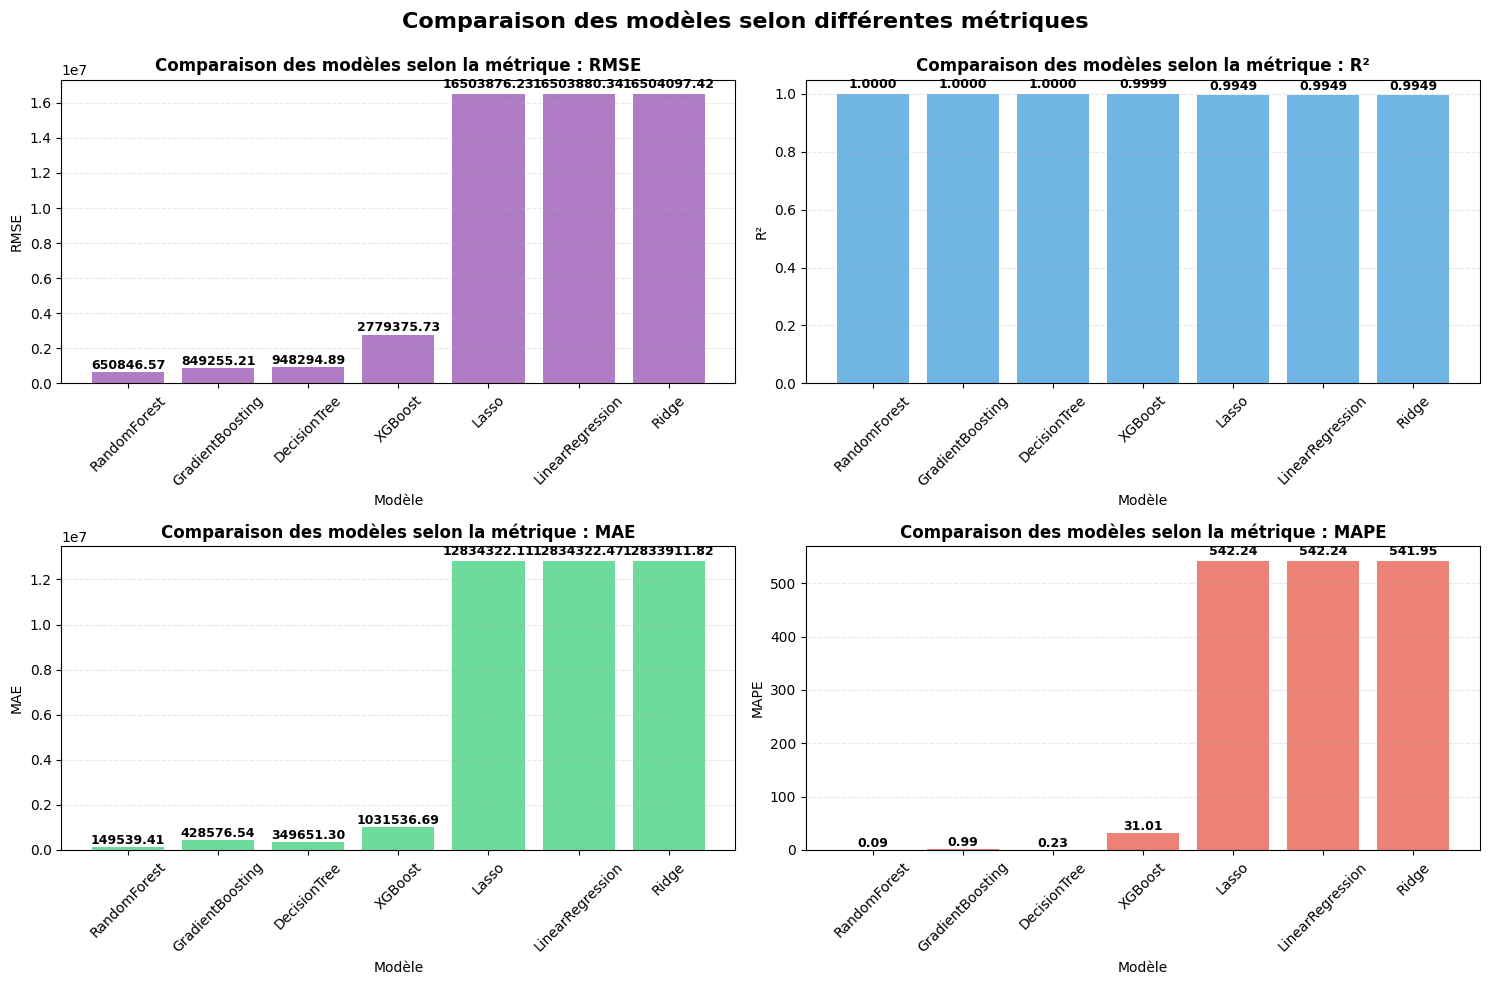

In [118]:
# Graphiques de comparaison des modèles
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparaison des modèles selon différentes métriques', fontsize=16, fontweight='bold')

metrics = ['RMSE', 'R²', 'MAE', 'MAPE']
colors = ['#8E44AD', '#3498DB', '#2ECC71', '#E74C3C']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i//2, i%2]
    
    # Créer le graphique en barres
    bars = ax.bar(results_df['Modèle'], results_df[metric], color=color, alpha=0.7, linewidth=1)
    
    # Ajouter les valeurs au-dessus des barres
    for bar, value in zip(bars, results_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}' if metric != 'R²' else f'{value:.4f}',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_title(f'Comparaison des modèles selon la métrique : {metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Modèle')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("plots/airplane_price/models_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


IMPORTANCE DES FEATURES

--- Importance des features pour DecisionTree ---
Top 10 features les plus importantes pour DecisionTree :
                      Feature  Importance
Catégorie_Capacité_Très Grand    0.847178
               Prix_par_siege    0.124733
     Catégorie_Capacité_Grand    0.022163
           Modèle_Airbus A350    0.003934
            Modèle_Boeing 777    0.001072
               Autonomie (km)    0.000400
     Catégorie_Capacité_Petit    0.000375
                     Capacité    0.000072
           Modèle_Airbus A320    0.000061
            Modèle_Boeing 737    0.000008


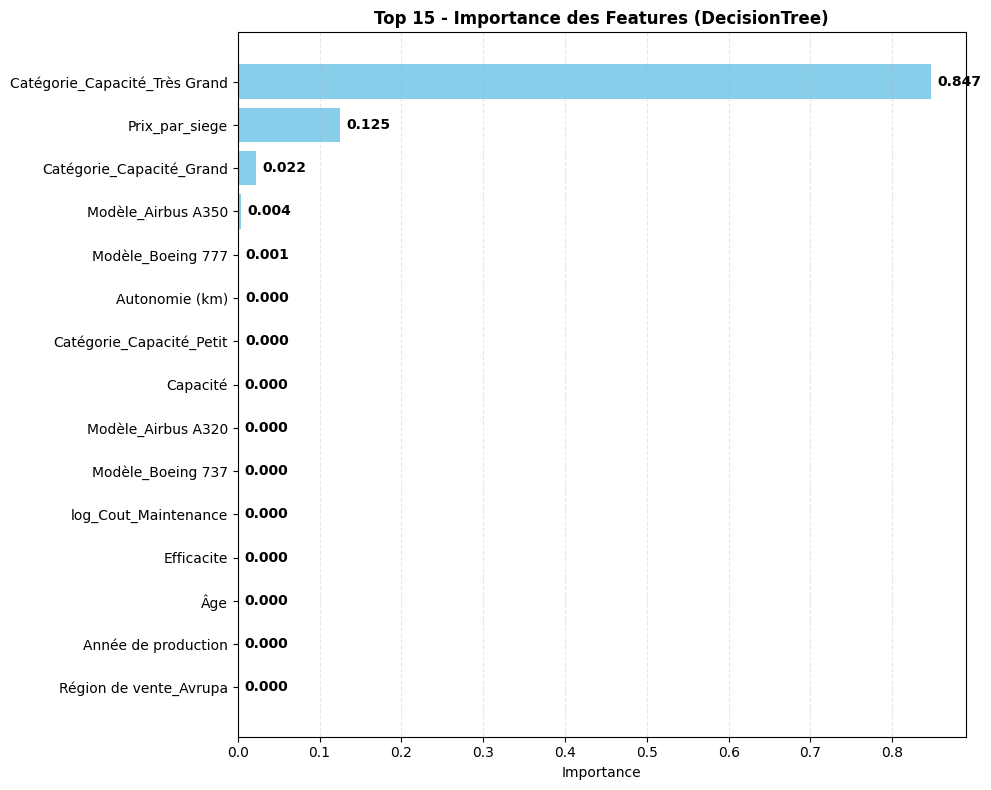

In [ ]:
# Analyse de l'importance des features pour les modèles qui le supportent
print("\n" + "="*60)
print("IMPORTANCE DES FEATURES")
print("="*60)

def get_feature_names(preprocessor, X):
    """Récupère les noms des features après préprocessing"""
    feature_names = []
    
    # Features numériques
    num_features = numerical_features
    feature_names.extend(num_features)
    
    # Features catégorielles (après OneHotEncoding)
    cat_transformer = preprocessor.named_transformers_['cat']
    if hasattr(cat_transformer, 'get_feature_names_out'):
        cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
    else:
        # Pour les versions plus anciennes de scikit-learn
        cat_feature_names = []
        for i, cat_feature in enumerate(categorical_features):
            categories = cat_transformer.categories_[i]
            for category in categories:
                cat_feature_names.append(f"{cat_feature}_{category}")
    
    feature_names.extend(cat_feature_names)
    
    return feature_names

# Obtenir les noms des features
fitted_preprocessor = best_model.named_steps['preprocessor']
feature_names = get_feature_names(fitted_preprocessor, X_train)

# Analyse de l'importance pour différents modèles
models_with_importance = ['RandomForest', 'GradientBoosting', 'XGBoost', 'DecisionTree']

for model_name in models_with_importance:
    if model_name in trained_models:
        print(f"\n--- Importance des features pour {model_name} ---")
        
        model = trained_models[model_name]
        regressor = model.named_steps['regressor']
        
        if hasattr(regressor, 'feature_importances_'):
            importances = regressor.feature_importances_
            
            # Créer un DataFrame avec les importances
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            print(f"Top 10 features les plus importantes pour {model_name} :")
            print(feature_importance_df.head(10).to_string(index=False))
            
            # Graphique de l'importance des features (top 15)
            plt.figure(figsize=(10, 8))
            top_features = feature_importance_df.head(15)
            
            bars = plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
            plt.yticks(range(len(top_features)), top_features['Feature'])
            plt.xlabel('Importance')
            plt.title(f'Top 15 - Importance des Features ({model_name})', fontweight='bold')
            plt.gca().invert_yaxis()
            
            # Ajouter les valeurs à côté des barres
            for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
                plt.text(bar.get_width() + max(top_features['Importance']) * 0.01, bar.get_y() + bar.get_height()/2,
                        f'{importance:.3f}', ha='left', va='center', fontweight='bold')
            
            plt.grid(axis='x', linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.savefig(f"plots/airplane_price/feature_importance_{model_name.lower()}.png", dpi=300, bbox_inches='tight')
            plt.show()

In [ ]:
# Analyse des coefficients pour les modèles linéaires
linear_models = ['LinearRegression', 'Ridge', 'Lasso', 'RandomForest']

for model_name in linear_models:
    if model_name in trained_models:
        print(f"\n--- Coefficients pour {model_name} ---")
        
        model = trained_models[model_name]
        regressor = model.named_steps['regressor']
        
        if hasattr(regressor, 'coef_'):
            coefficients = regressor.coef_
            
            # Créer un DataFrame avec les coefficients
            coef_df = pd.DataFrame({
                'Feature': feature_names,
                'Coefficient': coefficients
            })
            coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
            coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
            
            print(f"Top 10 coefficients les plus importants (en valeur absolue) pour {model_name} :")
            print(coef_df[['Feature', 'Coefficient']].head(10).to_string(index=False))


--- Coefficients pour LinearRegression ---
Top 10 coefficients les plus importants (en valeur absolue) pour LinearRegression :
                      Feature   Coefficient
               Prix_par_siege  2.067004e+08
            Modèle_Boeing 777  3.336664e+07
            Nombre de moteurs -2.157852e+07
           Modèle_Airbus A350 -2.150346e+07
     Catégorie_Capacité_Grand -2.011473e+07
               Autonomie (km)  1.651179e+07
                     Capacité  1.566133e+07
           Modèle_Airbus A320 -1.347220e+07
Catégorie_Capacité_Très Grand  1.186318e+07
                          Âge  8.042101e+06

--- Coefficients pour Ridge ---
Top 10 coefficients les plus importants (en valeur absolue) pour Ridge :
                      Feature   Coefficient
               Prix_par_siege  2.066789e+08
            Modèle_Boeing 777  3.336370e+07
            Nombre de moteurs -2.157606e+07
           Modèle_Airbus A350 -2.149655e+07
     Catégorie_Capacité_Grand -2.011655e+07
               Aut

In [121]:
# Sauvegarde du meilleur modèle
joblib.dump(best_model, "models/airplane_price/best_airplane_price_model.pkl")
print(f"\nLe meilleur modèle ({best_model.named_steps['regressor'].__class__.__name__}) a été sauvegardé sous 'best_airplane_price_model.pkl'")


Le meilleur modèle (RandomForestRegressor) a été sauvegardé sous 'best_airplane_price_model.pkl'



VISUALISATIONS POUR LE MEILLEUR MODÈLE


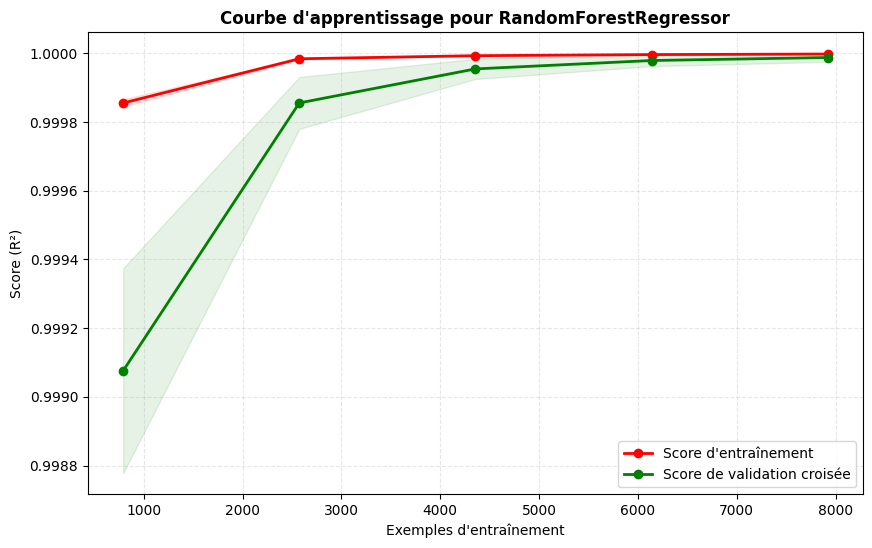

In [122]:

# Visualisation des résultats du meilleur modèle
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    
    axes.set_title(title, fontweight='bold')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Exemples d'entraînement")
    axes.set_ylabel("Score (R²)")
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='r2', return_times=True
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    axes.grid(True, linestyle='--', alpha=0.3)
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1, color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1, color="g",
    )
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Score d'entraînement", linewidth=2)
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Score de validation croisée", linewidth=2)
    axes.legend(loc="best")
    return plt

# Courbe d'apprentissage du meilleur modèle
print("\n" + "="*60)
print("VISUALISATIONS POUR LE MEILLEUR MODÈLE")
print("="*60)

plot_learning_curve(best_model, f"Courbe d'apprentissage pour {best_model.named_steps['regressor'].__class__.__name__}", X_train, y_train, cv=5)
plt.savefig("plots/airplane_price/learning_curve.png", dpi=300, bbox_inches='tight')
plt.show()

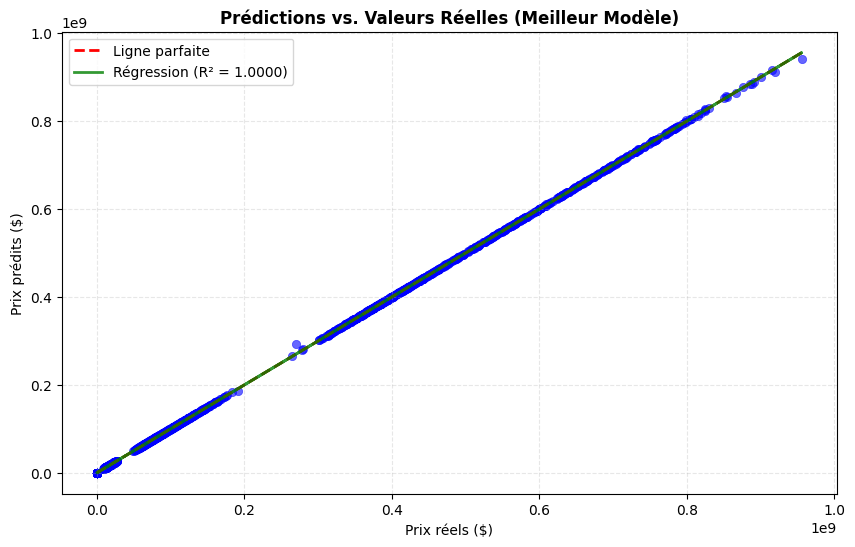

In [123]:
# Visualisation des prédictions vs. valeurs réelles
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='blue', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ligne parfaite")

# Ligne de régression
z = np.polyfit(y_test, y_pred_best, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "g-", alpha=0.8, linewidth=2, label=f"Régression (R² = {r2_score(y_test, y_pred_best):.4f})")

plt.xlabel("Prix réels ($)")
plt.ylabel("Prix prédits ($)")
plt.title("Prédictions vs. Valeurs Réelles (Meilleur Modèle)", fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plots/airplane_price/predictions_vs_reels.png", dpi=300, bbox_inches='tight')
plt.show()

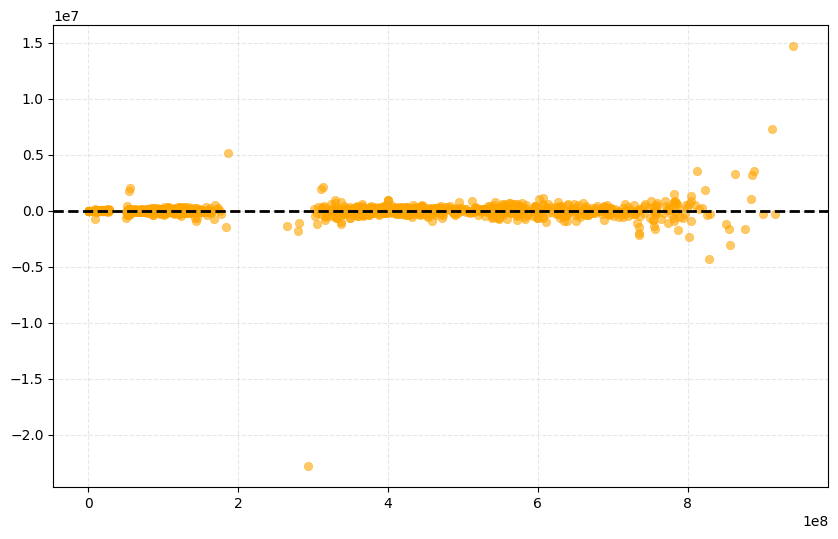

In [135]:
# Visualisation de l'homoscédasticité (résidus vs. prédictions)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.6, color='orange', linewidth=0.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plots/airplane_price/homoscedasticity.png", dpi=300, bbox_inches='tight')



In [136]:
print("\n" + "="*60)
print("ANALYSE TERMINÉE")
print("="*60)
print("Tous les graphiques ont été sauvegardés dans le dossier 'plots/airplane_price/'")
print("Le meilleur modèle a été sauvegardé sous 'models/airplane_price/best_airplane_price_model.pkl'")


ANALYSE TERMINÉE
Tous les graphiques ont été sauvegardés dans le dossier 'plots/airplane_price/'
Le meilleur modèle a été sauvegardé sous 'models/airplane_price/best_airplane_price_model.pkl'
